In [23]:
#Importing necessary modules
from google_play_scraper import app,Sort,reviews_all
import pandas as pd
import numpy as np
from google_play_scraper import Sort, reviews

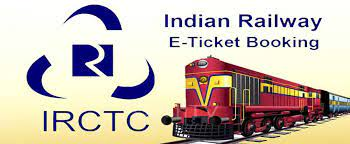

In [24]:
result, continuation_token = reviews(
    'cris.org.in.prs.ima', 
    lang='en', 
    country='us',
    count=10000,
    sort=Sort.NEWEST, 
)


In [25]:
#Assembling reviews into a pandas dataframe for better pipelining
df_review=pd.DataFrame(np.array(result),columns=['review'])
df_review=df_review.join(pd.DataFrame(df_review.pop('review').tolist()))

In [26]:
df_review.head(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,b06b4ad6-35c9-45df-aca4-66882aeef847,सशक्त गाँव समृद्ध भारत ClubKadakNath,https://play-lh.googleusercontent.com/a-/AFdZu...,Best site to book tickets for Indian Railways,5,0,None,2022-09-05 23:31:57,None,NaT
1,8c3fd539-c73b-48f6-8514-4044dcd33b22,suresh rathor,https://play-lh.googleusercontent.com/a-/AFdZu...,Good,5,0,None,2022-09-05 23:23:37,None,NaT
2,69bc906a-5bc5-4d37-aa4e-939c3e52fafd,Abhijit Dey,https://play-lh.googleusercontent.com/a-/AFdZu...,Good,5,0,4.1.27,2022-09-05 23:17:51,None,NaT
3,17088a44-9bc9-4ebd-9e39-e32909dbf2e0,muske praveen,https://play-lh.googleusercontent.com/a-/AFdZu...,👍,5,0,None,2022-09-05 23:13:02,None,NaT
4,53dc3306-a86a-4d91-9a32-c11a01e84989,Vijay Baranwal,https://play-lh.googleusercontent.com/a/AItbvm...,Very nice app,5,0,None,2022-09-05 23:11:33,None,NaT


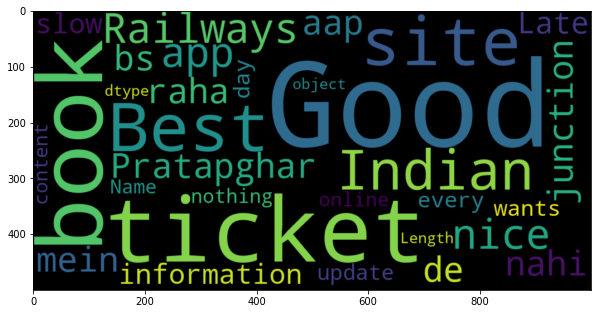

In [27]:
#Viewing some reviews...
import matplotlib.pyplot as plt
from wordcloud import WordCloud
plt.figure(figsize=(10,10))
reviews=str(df_review['content'])
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
words=WC.generate(reviews)
plt.imshow(words,interpolation='bilinear')
plt.show()

In [28]:
features=df_review['content']
targets=df_review['score']

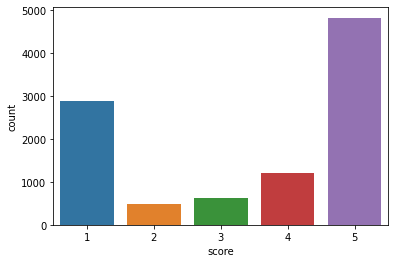

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=df_review,x=df_review['score'])
plt.show()

# Binary Classification

In [30]:
new_targets=[]
num_pos=0
num_neg=0
for rows in range(targets.shape[0]):
    temp_score=targets[rows]
    if temp_score>=3:
        new_targets.append(1)
        num_pos+=1
    else:
        new_targets.append(0)
        num_neg+=1
        

In [31]:
print('Number of positive reviews {}\nNumber of negative reviews {}'.format(num_pos,num_neg))

Number of positive reviews 6644
Number of negative reviews 3356


# Text Preprocessing

In [10]:
import nltk 
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PROMIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()

In [33]:
corpus=[]
for i in range(0,len(features)):
    pat = r'[^a-zA-z0-9]'
    text=features[i]
    review=re.sub(pat,' ',text)
    review=review.lower()
    review=review.split()
    review=[ps.stem(word) for word in review if word not in stopwords.words('english')]
    review=' '.join(review)
    corpus.append(review)

# Using LSTMs and Word Embeddings

In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
# Tokenizing ( Basically label encoding top 7000 unique words from the corpus to feed into the Embedding Layer)
num_words = 7000
tk = Tokenizer(oov_token='UNK', num_words=num_words+1)
tk.fit_on_texts(corpus)
vocabulary=len(tk.word_index)

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sentence_len=500
embedded_doc=pad_sequences(
    tk.texts_to_sequences(corpus),
    maxlen=sentence_len,
    padding="pre"
)

In [36]:
new_targets=np.array(new_targets)
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(embedded_doc,new_targets,random_state=42,test_size=0.3)
print("Training samples : {}\nTesting Samples : {}".format(len(X_train),len(X_test)))

Training samples : 7000
Testing Samples : 3000


In [37]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input,LSTM,Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
input_shape=X_train.shape[1]
i=Input(shape=(input_shape,))
x=Embedding(vocabulary+1,50)(i)
x=LSTM(100,return_sequences=False)(x)
x=Flatten()(x)
x=Dense(512,activation='relu')(x)
x=Dense(256,activation='relu')(x)
x=Dense(128,activation='relu')(x)
x=Dense(64,activation='relu')(x)
x=Dense(32,activation='relu')(x)
x=Dense(1,activation='sigmoid')(x)
model=Model(i,x)
print(model.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 50)           227750    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               51712     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [38]:
#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

In [39]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history=model.fit(X_train,Y_train,epochs=100,validation_split=0.1,callbacks=[es])

Epoch 1/100
197/197 [==============================] - 38s 192ms/step - loss: 0.4125 - acc: 0.8243 - val_loss: 0.3345 - val_acc: 0.8714
Epoch 2/100
197/197 [==============================] - 38s 193ms/step - loss: 0.2925 - acc: 0.8930 - val_loss: 0.3195 - val_acc: 0.8729
Epoch 3/100
197/197 [==============================] - 38s 193ms/step - loss: 0.2464 - acc: 0.9146 - val_loss: 0.3330 - val_acc: 0.8757
Epoch 00003: early stopping


In [42]:
# Model Evaluation
preds_LSTM_binary=model.predict(X_test)
preds_LSTM_binary[preds_LSTM_binary>=0.5]=1
preds_LSTM_binary[preds_LSTM_binary<0.5]=0

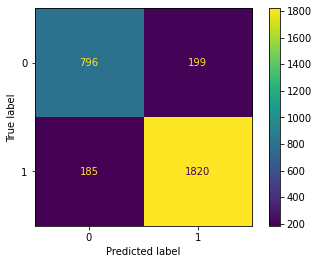

In [43]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm=confusion_matrix(Y_test,preds_LSTM_binary)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

From the confusion matrix, we can interpret the model is working pretty good!

# Generating live predictions on reviews

In [46]:
def predict_review_sentiment(review_cur):
    pat = r'[^a-zA-z0-9]'
    review_cur=re.sub(pat,' ',review_cur)
    review_cur=review_cur.lower()
    review_cur=review_cur.split()
    review_cur=[ps.stem(word) for word in review_cur if word not in stopwords.words('english')]
    review_cur=' '.join(review_cur)
    review=[]
    sentence_len=500
    review.append(review_cur)
    tokenized_review=pad_sequences(
    tk.texts_to_sequences(review),
    maxlen=sentence_len,
    padding="pre"
    )
    pred=model(tokenized_review)
    
    pred=tf.squeeze(pred)
    if pred>=0.5:
        pred=1
    else:
        pred=0
    return pred
while True:
    print("\n")
    print("Enter your review...")
    review=input()
    if review== "STOP":
        break
    live_prediction=predict_review_sentiment(review)
    if live_prediction==1:
         print('Thats a positive review...')
    else:
         print('That sounds you are upset with the App')
    



Enter your review...
This is a nice app
Thats a positive review...


Enter your review...
Worst app ever
That sounds you are upset with the App


Enter your review...
I like this app.
Thats a positive review...


Enter your review...
I hate this app
Thats a positive review...


Enter your review...
This app is incredible !
Thats a positive review...


Enter your review...
This app is very poor performing
That sounds you are upset with the App


Enter your review...
STOP
